# Online learning in the L96 framework

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from L96 import *
from EnKF import *
from utils import *
from parameterizations import *
import seaborn as sns
import matplotlib as mpl
from sklearn.model_selection import train_test_split

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

In [28]:
mpl.rcParams['figure.figsize'] = (8,5)
sns.set_style('whitegrid')
sns.set_context('talk')

In [10]:
# Load initial conditions for 
initX, initY = np.load('./data/initX.npy'), np.load('./data/initY.npy')
np.random.seed(123)

## Reference/"true" linear regression

In [11]:
h = xr.open_dataset('./data/L96TwoLevel_ref.nc')

In [12]:
features = np.ravel(h.X.values)
targets = np.ravel(h.B.values)

In [14]:
features.shape, targets.shape

((7200036,), (7200036,))

In [15]:
slope, intercept = np.polyfit(np.ravel(h.X.values), np.ravel(h.B.values), 1)
slope, intercept

(-0.30716963810423914, -0.2111813639516071)

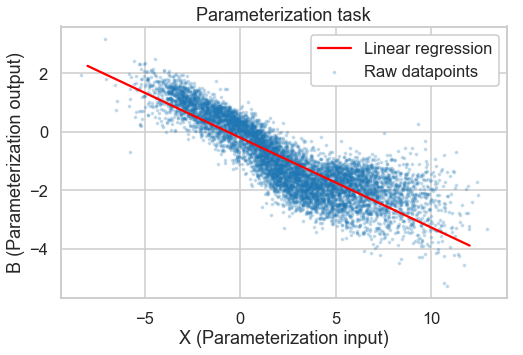

In [36]:
plt.scatter(features[::1000], targets[::1000], s=5, alpha=0.2, label='Raw datapoints');
plt.xlabel('X (Parameterization input)')
plt.ylabel('B (Parameterization output)')
plt.title('Parameterization task')
a = np.linspace(-8, 12, 100)
plt.plot(a, np.polyval((slope, intercept), a), label='Linear regression', c='red')
plt.legend(framealpha=1)
plt.savefig('figures/X-B-True.pdf', bbox_inches='tight')

## Create "wrong" linear regression with Keras

For online learning we assume that we do not have to completely start from scratch. We can always learn in a supervised manner, e.g. from a traditional paraemterization or a coarse grained dataset.

To emulate this "starting point" in the L96 setup, we will run a simulation with "wrong" parameters and use this simulation to train out initial machine learning methods.

In [65]:
l96_wrong = L96TwoLevel(
    X_init=initX, Y_init=initY, 
    F=7,   # default = 10
    h=2,  # default = 1
    c=5,    # default = 10
    b=5     # default = 10
)

In [66]:
l96_wrong.iterate(20)

In [67]:
features_wrong = np.ravel(l96_wrong.history.X.values)
targets_wrong = np.ravel(l96_wrong.history.B.values)

In [68]:
features_wrong.shape

(7236,)

In [69]:
slope_wrong, intercept_wrong = np.polyfit(features_wrong, targets_wrong, 1)
slope_wrong, intercept_wrong

(-0.7482297839541219, -0.38580039259452187)

(-8, 5)

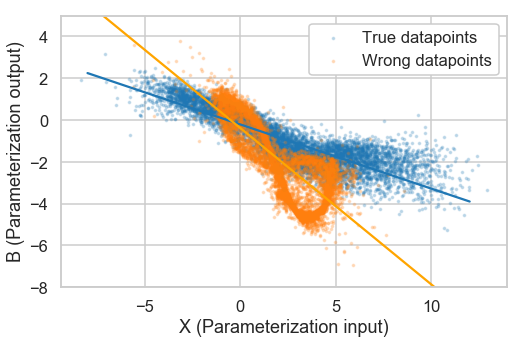

In [75]:
plt.scatter(features[::1000], targets[::1000], s=5, alpha=0.2, label='True datapoints');
plt.scatter(features_wrong, targets_wrong, s=5, alpha=0.2, label='Wrong datapoints');
a = np.linspace(-8, 12, 100)
plt.plot(a, np.polyval((slope, intercept), a), c=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765))
a = np.linspace(-8, 12, 100)
plt.plot(a, np.polyval((slope_wrong, intercept_wrong), a), c='orange')
plt.xlabel('X (Parameterization input)')
plt.ylabel('B (Parameterization output)')
plt.legend(framealpha=1)
plt.ylim(-8, 5)

### Linear regression in Keras

To learn online with stochastic gradient descent we will use tf.keras.

In [96]:
lr_net = keras.models.Sequential([
    Dense(1, input_shape=(1,))
])

In [97]:
learning_rate = 0.001
lr_net.compile(tf.keras.optimizers.Adam(learning_rate), 'mse')

In [98]:
# No need for validation, etc, since we are simply interested in a "wrong" starting point
lr_net.fit(features_wrong, targets_wrong, epochs=30, verbose=0);

In [101]:
l = lr_net.layers[0]

In [102]:
l.get_weights(), slope_wrong, intercept_wrong

([array([[-0.74689245]], dtype=float32), array([-0.3859751], dtype=float32)],
 -0.7482297839541219,
 -0.38580039259452187)

In [103]:
lr_net.save('/project/meteo/w2w/A6/S.Rasp/tmp/lr.h5')

In [104]:
class NNParam():
    """Parameterization class that can be used inside a L96 object"""
    def __init__(self, keras_net):
        self.net = keras_net
    def __call__(self, x):
        return self.net.predict_on_batch(x).squeeze(-1)

## Create online learning setup

In [105]:
class L96TwoLevelNN(L96TwoLevel):
    """
    Slightly modified L96 object for online learning. 
    Main difference is that the parameterization term B is is not actually applied. 
    That way we can do this externaly in our online learning loop.
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def step(self):
        """Integrate one time step"""
        
        k1_X = self._rhs_X_dt(self.X, B=0)
        k2_X = self._rhs_X_dt(self.X + k1_X / 2, B=0)
        k3_X = self._rhs_X_dt(self.X + k2_X / 2, B=0)
        k4_X = self._rhs_X_dt(self.X + k3_X, B=0)


        self.X += 1 / 6 * (k1_X + 2 * k2_X + 2 * k3_X + k4_X)
        
        B = self.parameterization(self.X)
#         self.X += B * self.dt

        self.step_count += 1
        if self.step_count % self.save_steps == 0:
            Y_mean = self.Y.reshape(self.K, self.J).mean(1)
            Y2_mean = (self.Y.reshape(self.K, self.J)**2).mean(1)
            self._history_X.append(self.X.copy())
            self._history_Y_mean.append(Y_mean.copy())
            self._history_Y2_mean.append(Y2_mean.copy())
            self._history_B.append(B.copy())
            if not self.noYhist:
                self._history_Y.append(self.Y.copy())

In [320]:
# Load the "wrongly" pretrained model
lr_net = keras.models.load_model('/project/meteo/w2w/A6/S.Rasp/tmp/lr.h5')
lr_net.optimizer.lr = 0.001
ml_param = NNParam(lr_net)

In [321]:
# Create the two models
# This is the machine learning model. Either linear regression or a neural network
l96_ml = L96TwoLevelNN(parameterization=ml_param, X_init=initX, Y_init=initY, save_dt=0.001)
# This is the true model (aka the CRM) that will be nudged
l96_crm = L96TwoLevel(integration_type='uncoupled', X_init=initX, Y_init=initY, save_dt=0.001)

In [324]:
class OnlineLearning():
    def __init__(self, l96_ml, l96_crm, update_frequency=1, dt_factor=1):
        self.l96_ml, self.l96_crm = l96_ml, l96_crm
        self.update_frequency, self.dt_factor = update_frequency, dt_factor
        self.diff_history, self.loss_history, self.parameter_history = [], [], []
        self.feature_memory, self.target_memory = [], []
    def iterate(self, nsteps):
        for i in tqdm(range(nsteps)):
            # Compute the difference
            diff = self.l96_crm.X - self.l96_ml.X
            self.diff_history.append(diff)
            # Apply the difference divied by the time step as an extra forcing for the CRM
            self.l96_crm.F = 10 - diff/self.l96_crm.dt
            # Integrate the CRM forward one time step
            self.l96_crm.step()
            
            # Now integrate the NN model forward. This evolves only X without the parameterization term B.
            self.l96_ml.step()
            feature = self.l96_ml.X.copy()
            self.feature_memory.append(feature)
            # Get the ML parameterization output
            B = nn_param(feature)
            # Compute the target: CRM - ML(only dynamics) / dt
            target = (self.l96_crm.X - feature) / self.l96_ml.dt
            self.target_memory.append(target)
            # Add the parameterization term after computing the target
            self.l96_ml.X += B * self.l96_ml.dt
            
            if i % self.update_frequency == 0:
                # Train the neural network. Batch size = K
                features = np.array(feature_memory).flatten()
                targets = np.array(target_memory).flatten()
                loss = ml_param.net.train_on_batch(features, targets)
                self.loss_history.append(loss)
                self.parameter_history.append(ml_param.net.get_weights())
                self.target_memory = []
                self.feature_memory = []

In [325]:
ol = OnlineLearning(l96_ml, l96_crm)

In [326]:
ol.iterate(4000)

In [ ]:
ol.

In [283]:
nsteps = 20000
update_frequency = 10
target_memory = []
feature_memory = []
for i in tqdm(range(nsteps)):
    # Compute the difference
    diff = l96_crm.X - l96_ml.X
    diff_history.append(diff)
    # Apply the difference divied by the time step as an extra forcing for the CRM
    l96_crm.F = 10 - diff/l96_crm.dt
    # Integrate the CRM forward one time step
    l96_crm.step()
    
    # Now integrate the NN model forward. This evolves only X without the parameterization term B.
    l96_ml.step()
    feature = l96_ml.X.copy()
    feature_memory.append(feature)
    # Get the ML parameterization output
    B = nn_param(l96_ml.X)
    # Compute the target: CRM - ML(only dynamics) / dt
    target = (l96_crm.X - l96_ml.X) / l96_ml.dt
    target_memory.append(target)
    # Add the parameterization term after computing the target
    l96_ml.X += B * l96_ml.dt
    
    if i % update_frequency == 0:
        # Train the neural network. Batch size = K
        loss = ml_param.net.train_on_batch(np.array(feature_memory).flatten(), np.array(target_memory).flatten())
        loss_history.append(loss)
        parameter_history.append(ml_param.net.get_weights())
        target_memory = []
        feature_memory = []

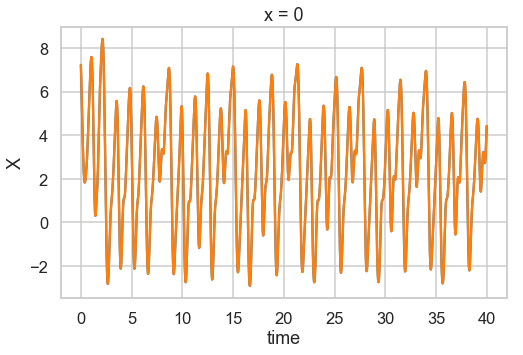

In [284]:
l96_ml.history.X.isel(x=0).plot();
l96_crm.history.X.isel(x=0).plot();

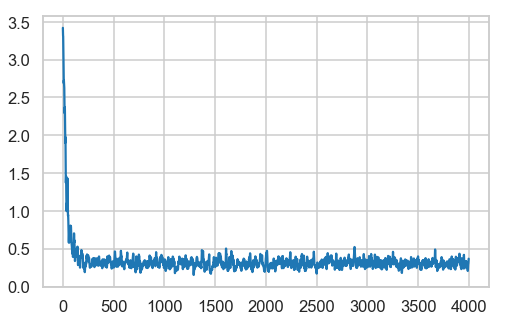

In [285]:
plt.plot(loss_history)

In [286]:
dh = np.array(diff_history); dh.shape

(40000, 36)

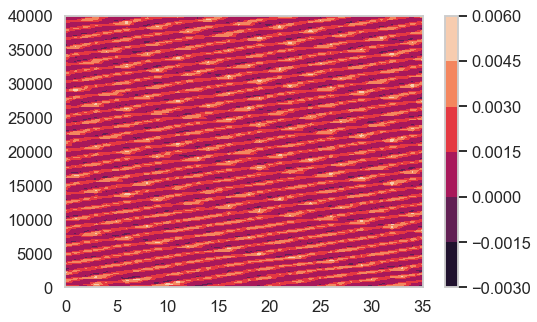

In [287]:
plt.contourf(dh)
plt.colorbar()

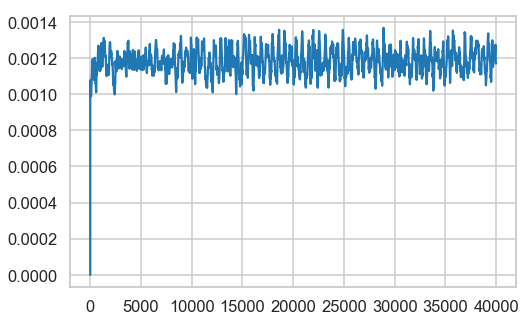

In [290]:
plt.plot(np.abs(dh.mean(1)))

In [288]:
ph = np.array(parameter_history).squeeze(); ph.shape

(4000, 2)

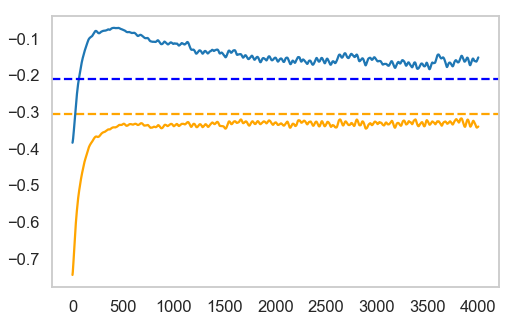

In [289]:
plt.plot(ph[:, 0], c='orange')
plt.axhline(slope, c='orange', ls='--')
plt.plot(ph[:, 1])
plt.axhline(intercept, c='blue', ls='--')
plt.grid()

### Test with the "true" parameterization

In [292]:
poly_param = PolyParam((slope, intercept))

In [293]:
# Create the two models
# This is the machine learning model. Either linear regression or a neural network
l96_ml = L96TwoLevelNN(parameterization=poly_param, X_init=initX, Y_init=initY, save_dt=0.001)
# This is the true model (aka the CRM) that will be nudged
l96_crm = L96TwoLevel(integration_type='uncoupled', X_init=initX, Y_init=initY, save_dt=0.001)

In [295]:
loss_history = []
parameter_history = []
diff_history = []

In [296]:
nsteps = 10000
update_frequency = 10
target_memory = []
feature_memory = []
for i in tqdm(range(nsteps)):
    # Compute the difference
    diff = l96_crm.X - l96_ml.X
    diff_history.append(diff)
    # Apply the difference divied by the time step as an extra forcing for the CRM
    l96_crm.F = 10 - diff/l96_crm.dt
    # Integrate the CRM forward one time step
    l96_crm.step()
    
    # Now integrate the NN model forward. This evolves only X without the parameterization term B.
    l96_ml.step()
    feature = l96_ml.X.copy()
    feature_memory.append(feature)
    # Get the ML parameterization output
    B = nn_param(l96_ml.X)
    # Compute the target: CRM - ML(only dynamics) / dt
    target = (l96_crm.X - l96_ml.X) / l96_ml.dt
    target_memory.append(target)
    # Add the parameterization term after computing the target
    l96_ml.X += B * l96_ml.dt
    
#     if i % update_frequency == 0:
#         # Train the neural network. Batch size = K
#         loss = ml_param.net.train_on_batch(np.array(feature_memory).flatten(), np.array(target_memory).flatten())
#         loss_history.append(loss)
#         parameter_history.append(ml_param.net.get_weights())
#         target_memory = []
#         feature_memory = []

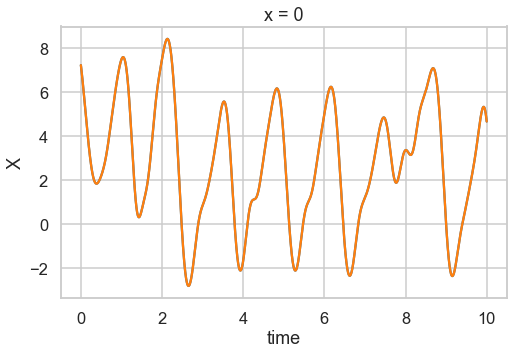

In [297]:
l96_ml.history.X.isel(x=0).plot();
l96_crm.history.X.isel(x=0).plot();

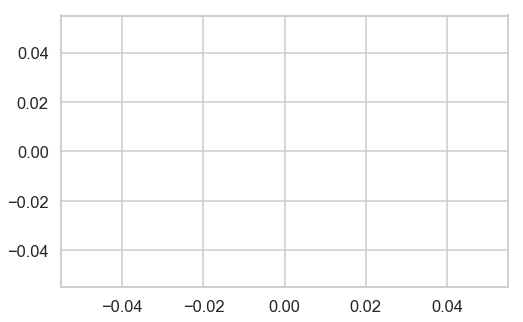

In [298]:
plt.plot(loss_history)

In [299]:
dh = np.array(diff_history); dh.shape

(10000, 36)

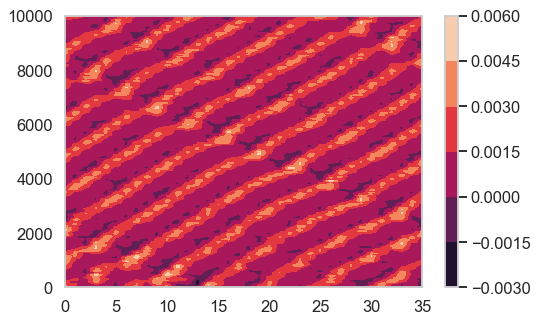

In [300]:
plt.contourf(dh)
plt.colorbar()

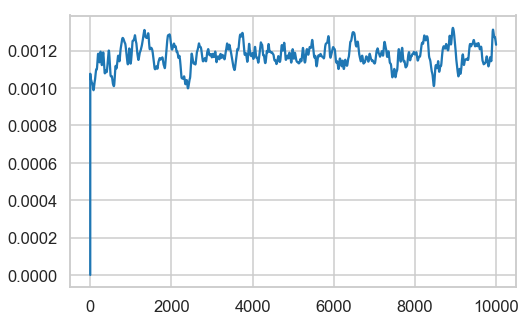

In [301]:
plt.plot(np.abs(dh.mean(1)))

### Several CRM time steps per GCM time step

In [166]:
learning_rate

0.001

In [167]:
# Load the "wrongly" pretrained model
lr_net = keras.models.load_model('/project/meteo/w2w/A6/S.Rasp/tmp/lr.h5')
lr_net.optimizer.lr = 0.0001
ml_param = NNParam(lr_net)

In [168]:
# Create the two models
dt_factor = 10
# This is the machine learning model. This time this model will have a ten times bigger time step
l96_ml = L96TwoLevelNN(parameterization=ml_param, X_init=initX, Y_init=initY, save_dt=0.01, dt=0.001*dt_factor)
# This is the true model (aka the CRM) that will be nudged
l96_crm = L96TwoLevel(integration_type='uncoupled', X_init=initX, Y_init=initY, save_dt=0.001, dt=0.001)

In [169]:
nsteps = 4000
update_frequency = 20
loss_history = []
parameter_history = []
diff_history = []
target_memory = []
feature_memory = []
for i in tqdm(range(nsteps)):
    # Compute the difference
    diff = l96_crm.X - l96_ml.X
    diff_history.append(diff.mean())
    # Apply the difference divied by the time step as an extra forcing for the CRM
    l96_crm.F = 10 - diff/l96_crm.dt/dt_factor
    # Integrate the CRM forward ten time steps
    for _ in range(dt_factor): l96_crm.step()
    
    # Now integrate the NN model forward. This evolves only X without the parameterization term B.
    l96_ml.step()
    feature = l96_ml.X
    # Get the ML parameterization output
    B = nn_param(l96_ml.X)
    # Compute the target: CRM(t+1) - ML(t) / dt
    target = (l96_crm.X - l96_ml.X) / l96_ml.dt
    # Add the parameterization term after computing the target
    l96_ml.X += B * l96_ml.dt
    
    #if update_frequency % i == 0:
    # Train the neural network. Batch size = K
    loss = ml_param.net.train_on_batch(l96_ml.X, target)
    loss_history.append(loss)
    parameter_history.append(ml_param.net.get_weights())

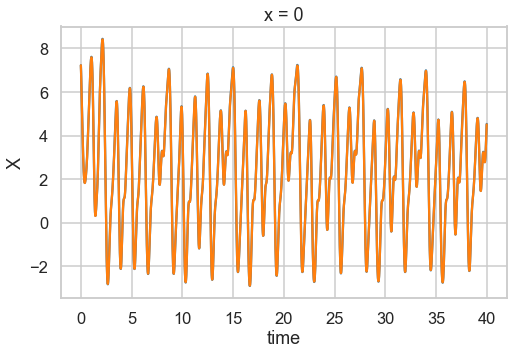

In [171]:
l96_ml.history.X.isel(x=0).plot();
l96_crm.history.X.isel(x=0).plot();

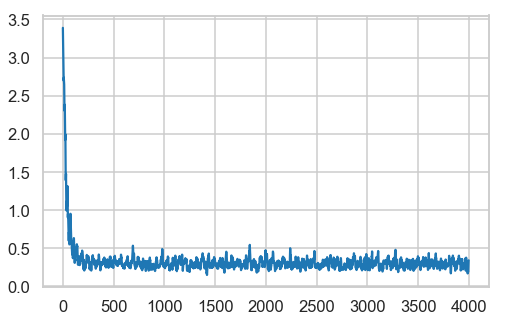

In [173]:
plt.plot(loss_history)

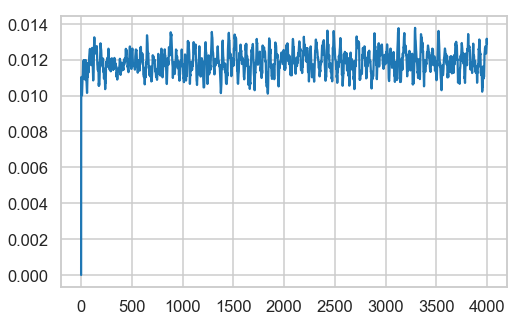

In [174]:
plt.plot(diff_history)

In [175]:
parameter_history = np.array(parameter_history).squeeze(); parameter_history.shape

(4000, 2)

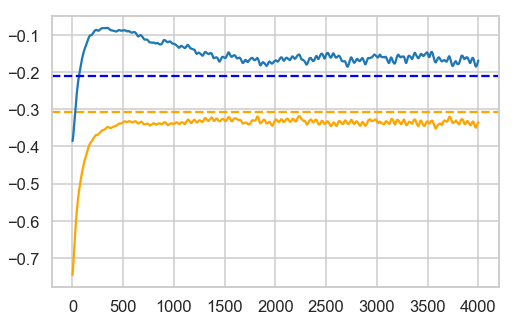

In [176]:
plt.plot(parameter_history[:, 0], c='orange')
plt.axhline(slope, c='orange', ls='--')
plt.plot(parameter_history[:, 1])
plt.axhline(intercept, c='blue', ls='--')

## Same with neural net

In [303]:
nnet = keras.models.Sequential([
    Dense(32, input_shape=(1,), activation='elu'),
    Dense(32, activation='elu'),
    Dense(1)
])

In [304]:
nnet.compile('adam', 'mse')

In [305]:
nnet.fit(features_wrong, targets_wrong, epochs=30, verbose=1)

Epoch 1/30
7236/7236 [==============================] - 2s 326us/step - loss: 1.0110
Epoch 2/30
7236/7236 [==============================] - 1s 184us/step - loss: 0.9056
Epoch 3/30
7236/7236 [==============================] - 1s 185us/step - loss: 0.8792
Epoch 4/30
7236/7236 [==============================] - 1s 185us/step - loss: 0.8461
Epoch 5/30
7236/7236 [==============================] - 1s 183us/step - loss: 0.8049
Epoch 6/30
7236/7236 [==============================] - 1s 185us/step - loss: 0.7798
Epoch 7/30
7236/7236 [==============================] - 1s 176us/step - loss: 0.7484
Epoch 8/30
7236/7236 [==============================] - 1s 178us/step - loss: 0.7454
Epoch 9/30
7236/7236 [==============================] - 1s 176us/step - loss: 0.7313
Epoch 10/30
7236/7236 [==============================] - 1s 174us/step - loss: 0.7233
Epoch 11/30
7236/7236 [==============================] - 1s 171us/step - loss: 0.7216
Epoch 12/30
7236/7236 [==============================] - 1s 171

In [306]:
nnet.save('/project/meteo/w2w/A6/S.Rasp/tmp/nn.h5')

In [307]:
nnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                64        
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


In [308]:
nnet2= keras.models.load_model('/project/meteo/w2w/A6/S.Rasp/tmp/nn.h5')
nn_param = NNParam(nnet2)

In [309]:
l96_nn = L96TwoLevelNN(parameterization=nn_param, X_init=initX, Y_init=initY, save_dt=0.01, dt=0.01)
l96_crm = L96TwoLevel(integration_type='uncoupled', X_init=initX, Y_init=initY, save_dt=0.01)

In [310]:
loss_history = []
parameter_history = []
diff_history = []
for i in tqdm(range(2000)):
    diff = l96_crm.X - l96_nn.X
    diff_history.append(diff)
    l96_crm.F = 10-diff/l96_crm.dt/10
    for i in range(10):
        l96_crm.step()
    
    l96_nn.step()  # Only X
    feature = l96_nn.X.copy()
    B = nn_param(l96_nn.X)
    target = (l96_crm.X - l96_nn.X) / l96_nn.dt
    l96_nn.X += B * l96_nn.dt
    
    loss = nn_param.net.train_on_batch(l96_nn.X, target)
    loss_history.append(loss)
    parameter_history.append(nn_param.net.get_weights())

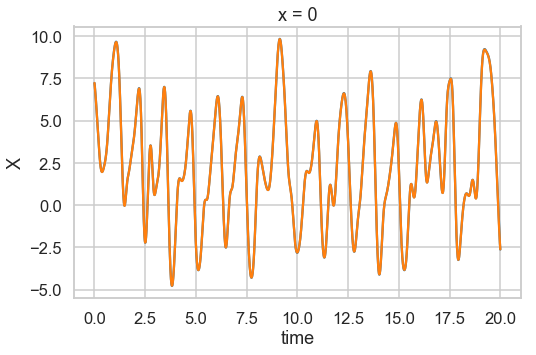

In [311]:
l96_nn.history.X.isel(x=0).plot();
l96_crm.history.X.isel(x=0).plot();

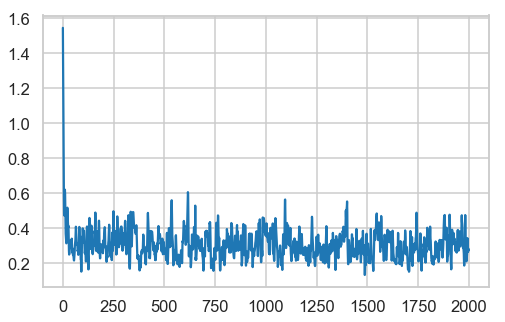

In [312]:
plt.plot(loss_history)

In [315]:
dh = np.array(diff_history); dh.shape

(2000, 36)

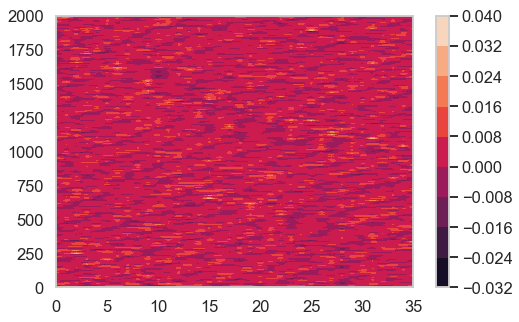

In [316]:
plt.contourf(dh)
plt.colorbar()

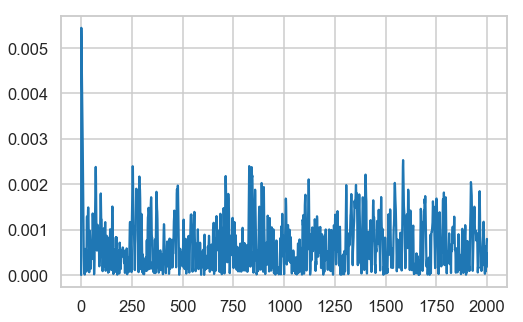

In [317]:
plt.plot(np.abs(dh.mean(1)))

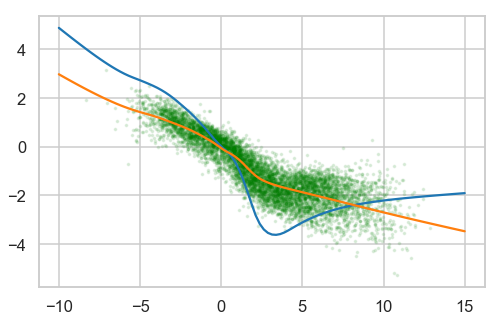

In [318]:
plt.scatter(features[::1000], targets[::1000], s=5, alpha=0.1, c='g');
tmp = np.linspace(-10, 15, 100)
plt.plot(tmp, nnet.predict(tmp))
plt.plot(tmp, nnet2.predict(tmp))